In [1]:
import CommonFunc
import pandas as pd

df = pd.read_csv('resources/CO2Emissions_Canada.csv')
df.drop_duplicates()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


In [2]:
#encoding categorical data
from sklearn.preprocessing import LabelEncoder

def printDict(dictionary)->str:
    string = ''
    for k, v in dictionary.items():
        string += k.__str__() + '   ' + v.__str__() + '\n'
    return string
    

numdata = pd.DataFrame(df[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
                           'CO2 Emissions(g/km)']])

label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()
label_encoder_3 = LabelEncoder()

vehicle_class = df[['Vehicle Class']].values.ravel()
fuel_type = df[['Fuel Type']].values.ravel()
transmission = df[['Transmission']].values.ravel()

encoded_vehicle_class = label_encoder_1.fit_transform(vehicle_class)
encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
encoded_transmission = label_encoder_3.fit_transform(transmission)

enc_1 = dict(zip(label_encoder_1.classes_,range(len(label_encoder_1.classes_))))
enc_2 = dict(zip(label_encoder_2.classes_,range(len(label_encoder_2.classes_))))
enc_3 = dict(zip(label_encoder_3.classes_,range(len(label_encoder_3.classes_))))

print(CommonFunc.printDict(enc_1))
print(CommonFunc.printDict(enc_2))
print(CommonFunc.printDict(enc_3))

COMPACT   0
FULL-SIZE   1
MID-SIZE   2
MINICOMPACT   3
MINIVAN   4
PICKUP TRUCK - SMALL   5
PICKUP TRUCK - STANDARD   6
SPECIAL PURPOSE VEHICLE   7
STATION WAGON - MID-SIZE   8
STATION WAGON - SMALL   9
SUBCOMPACT   10
SUV - SMALL   11
SUV - STANDARD   12
TWO-SEATER   13
VAN - CARGO   14
VAN - PASSENGER   15

D   0
E   1
N   2
X   3
Z   4

A10   0
A4   1
A5   2
A6   3
A7   4
A8   5
A9   6
AM5   7
AM6   8
AM7   9
AM8   10
AM9   11
AS10   12
AS4   13
AS5   14
AS6   15
AS7   16
AS8   17
AS9   18
AV   19
AV10   20
AV6   21
AV7   22
AV8   23
M5   24
M6   25
M7   26



In [3]:
X_ = numdata[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City (L/100 km)', 
                           'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)']]
X_['Vehicle Class'] = encoded_vehicle_class
X_['Transmission'] = encoded_fuel_type
X_['Fuel Type'] = encoded_transmission
feature_names = X_.columns
X=X_.values

y = numdata[['CO2 Emissions(g/km)']].values.ravel()

*****************
Метрики качества:
*****************
MAE: 1.7134401111
MSE: 7.4275623454
RMSE: 2.7253554530
R²: 0.9978405910


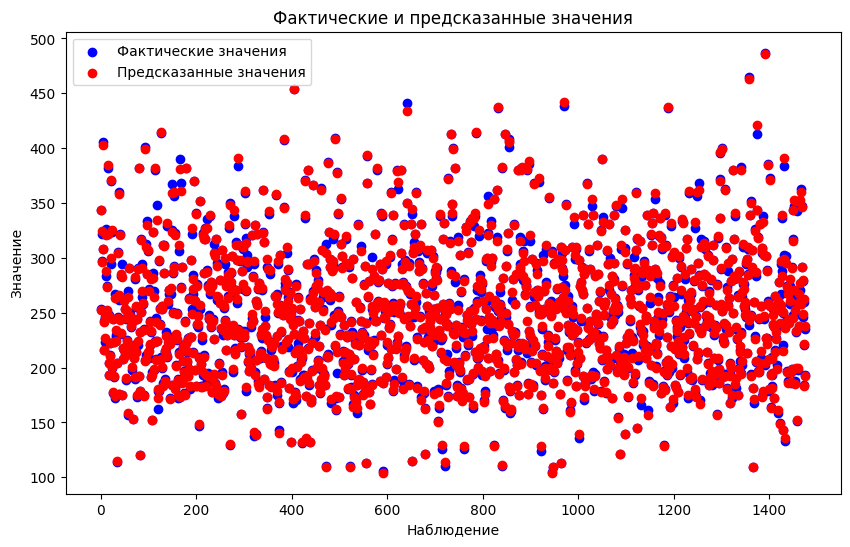

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\CommonFunc.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


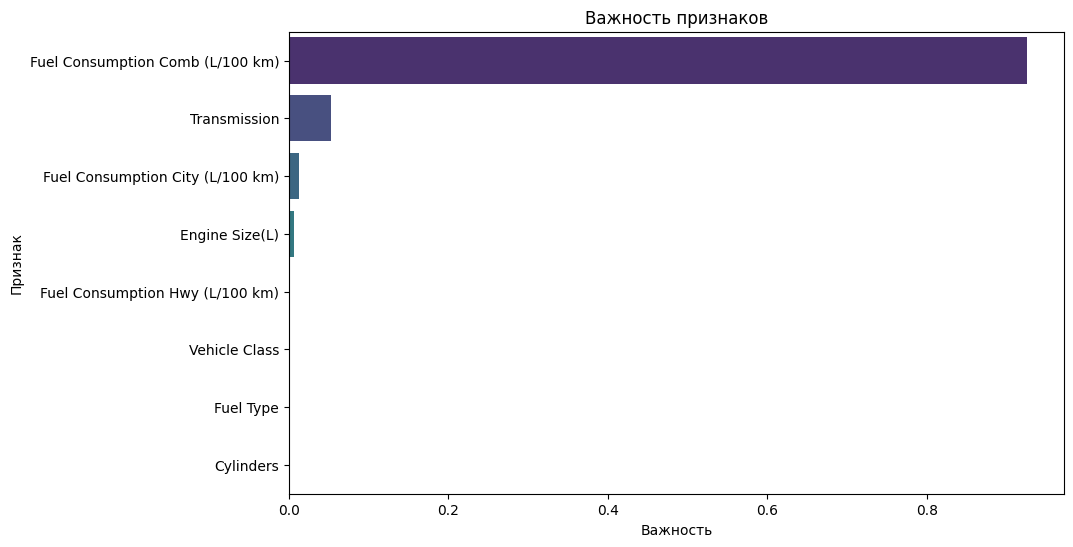

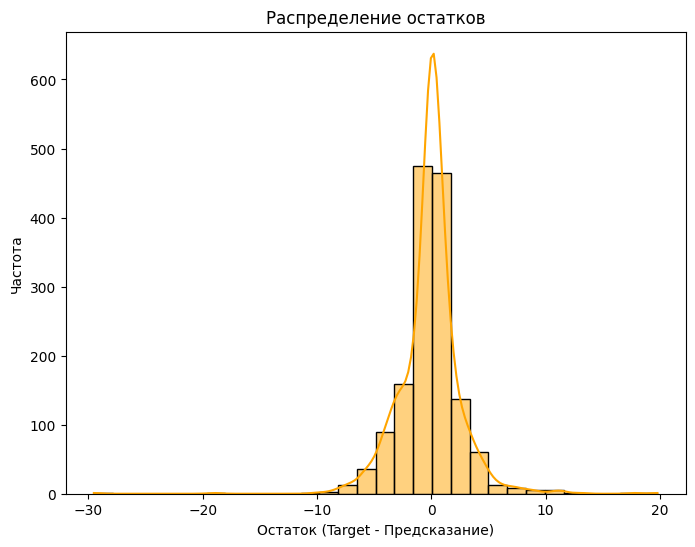

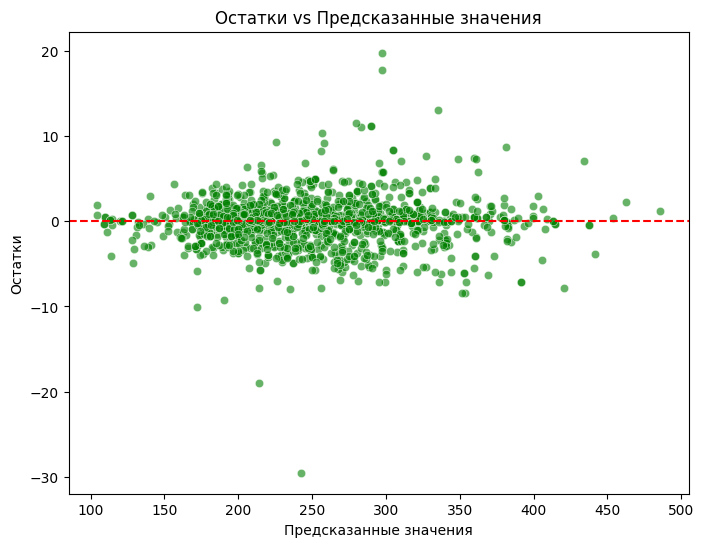

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели Gradient Boosting Regressor
rfr = RandomForestRegressor() # параметры
rfr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

# Важность признаков
CommonFunc.getImportances(rfr.feature_importances_, feature_names)

CommonFunc.getRemains(y_test, y_pred)


Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
*****************
Метрики качества:
*****************
MAE: 1.5935005317
MSE: 9.0850510112
RMSE: 3.0141418366
R²: 0.9973587107


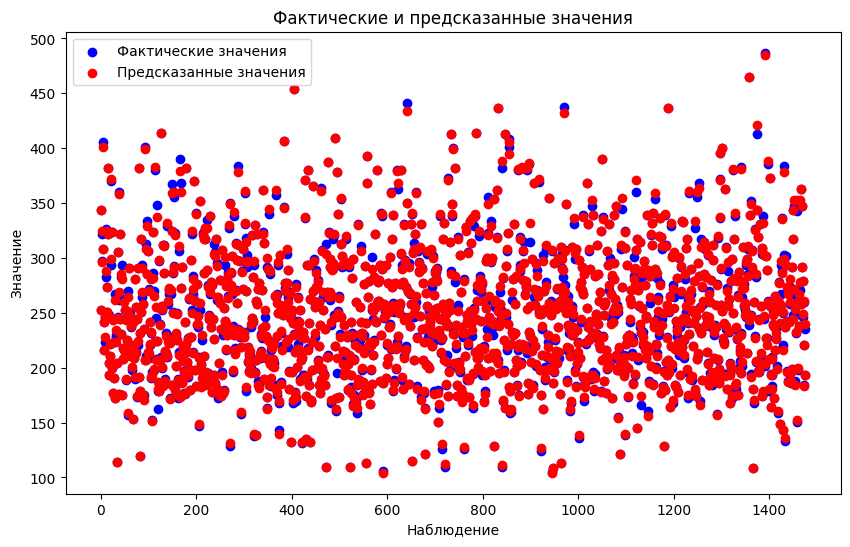

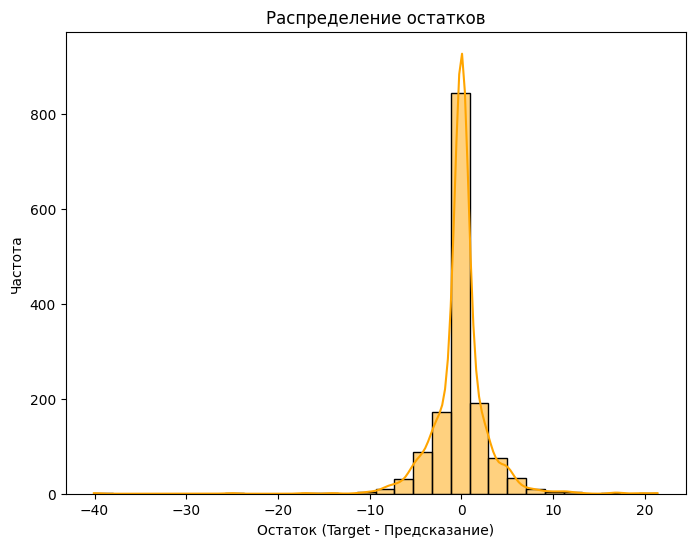

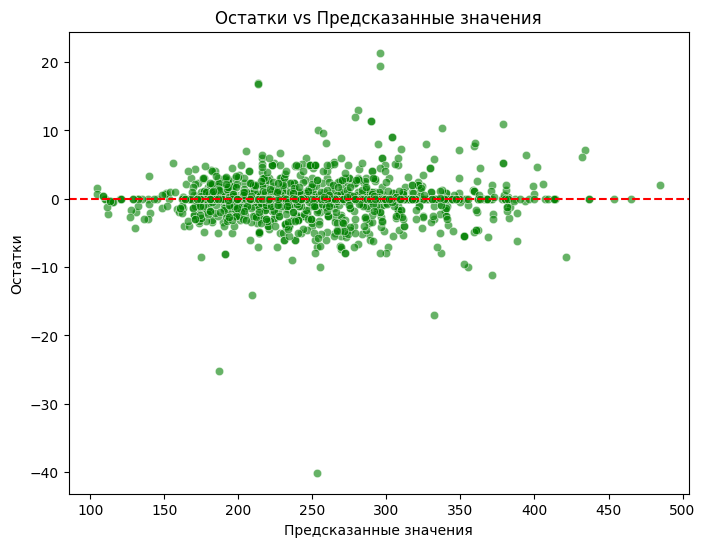

In [6]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

In [7]:
#мой автомобиль (в реальности 149 - 191 г/км)
my_y = rfr.predict(((2.0, 0, 7.3, 4.5, 6.5, 3, 0, 25),))
print(my_y) 

[163.0235]


*****************
Метрики качества:
*****************
MAE: 2.4830855882
MSE: 11.2205523996
RMSE: 3.3497093008
R²: 0.9967378582


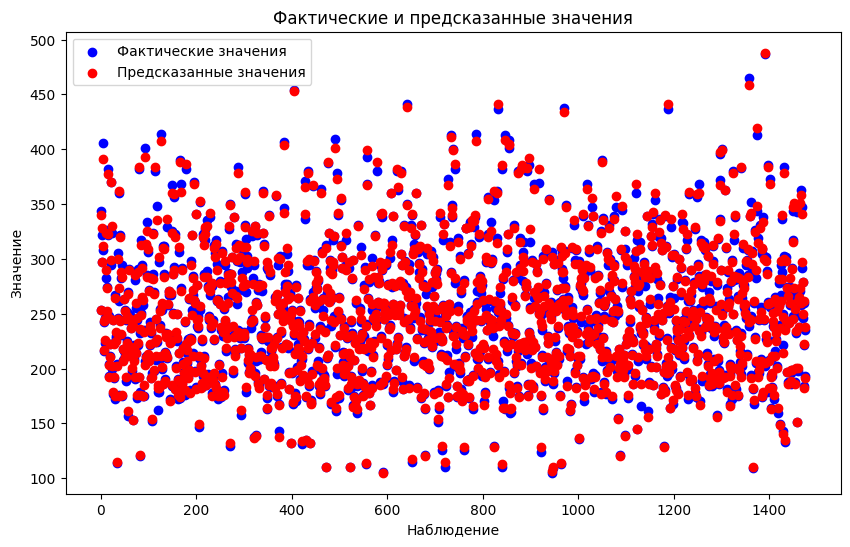

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() # параметры
gbr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = gbr.predict(X_test)

# Вычисление метрик
gbr_metrics = CommonFunc.getMetrics(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 5908, number of used features: 8
[LightGBM] [Info] Start training from score 250.939573
*****************
Метрики качества:
*****************
MAE: 2.1814265590
MSE: 10.2891640133
RMSE: 3.2076726786
R²: 0.9970086400


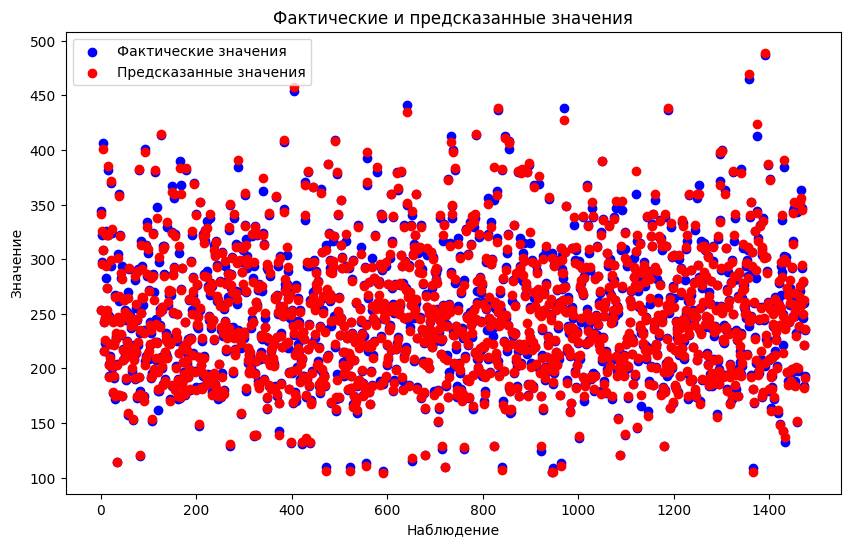

In [9]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 1.8705270311
MSE: 8.2658872501
RMSE: 2.8750456083
R²: 0.9975968599


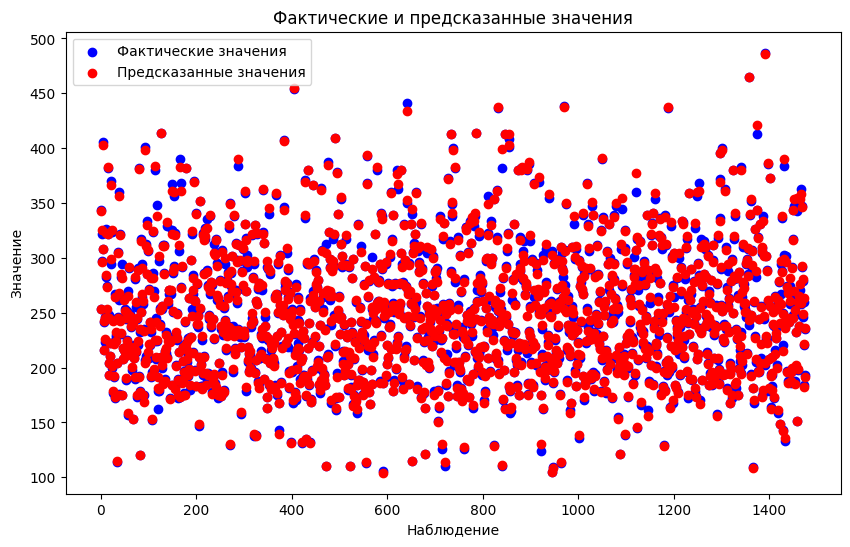

In [10]:
from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}
*****************
Метрики качества:
*****************
MAE: 11.0163031427
MSE: 395.4015001569
RMSE: 19.8847051815
R²: 0.8850452527


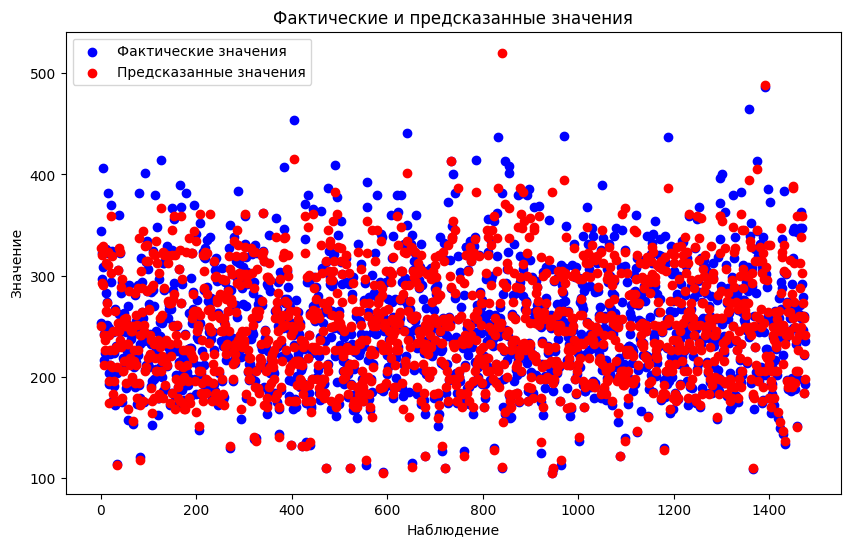

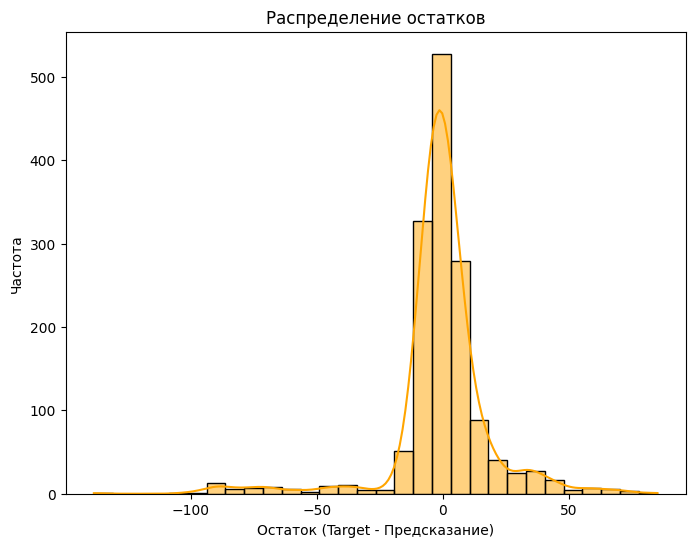

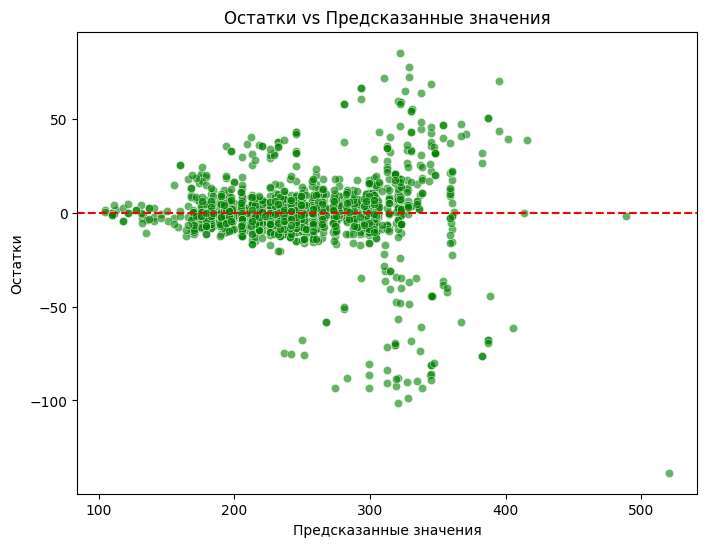

In [11]:
from sklearn.model_selection import GridSearchCV

X = numdata[['Fuel Consumption City (L/100 km)']]
y = numdata[['CO2 Emissions(g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5

Best parameters found: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}
*****************
Метрики качества:
*****************
MAE: 26.0185127777
MSE: 1273.7132142943
RMSE: 35.6891189902
R²: 0.6296944230


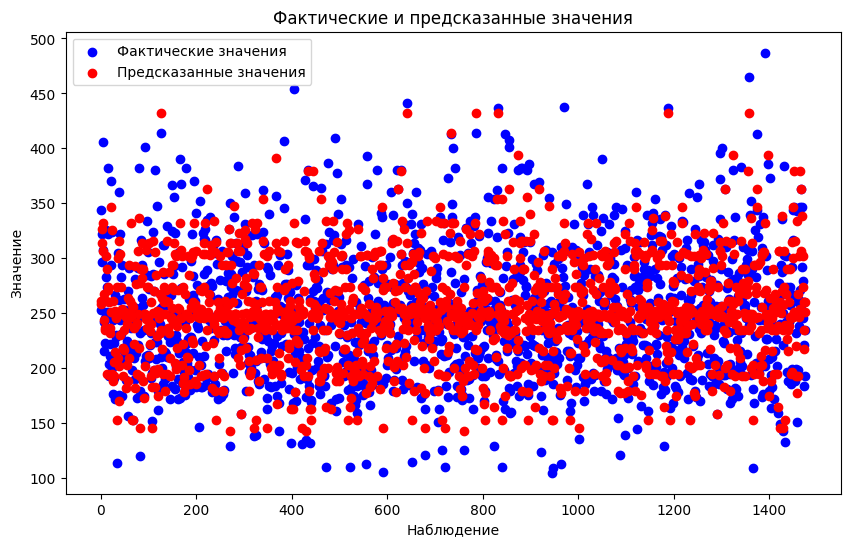

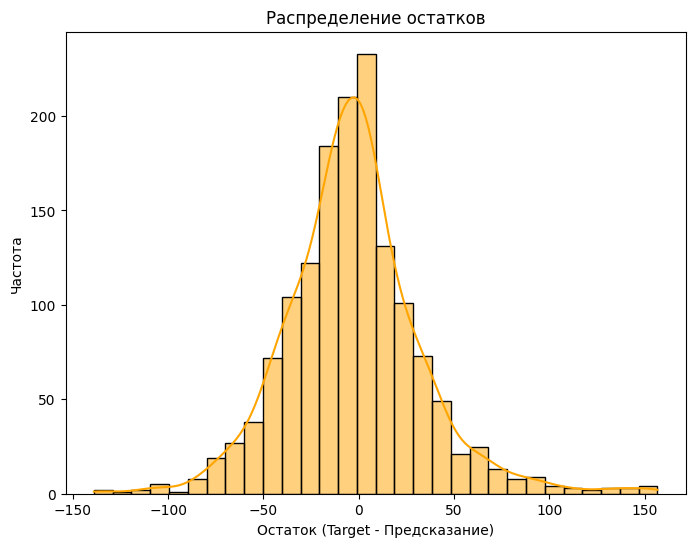

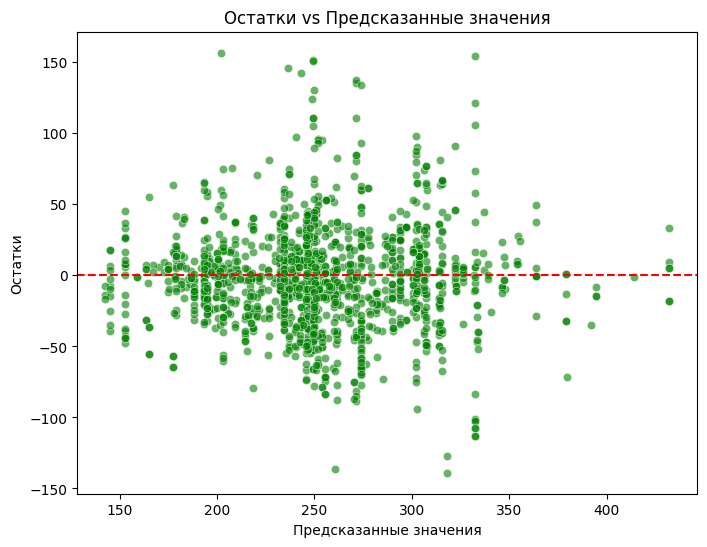

In [12]:
X = pd.DataFrame()
X['Vehicle Class'] = encoded_vehicle_class
X['Transmission'] = encoded_fuel_type
X['Fuel Type'] = encoded_transmission

y = numdata[['CO2 Emissions(g/km)']].values.ravel()

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Создание и обучение модели Gradient Boosting Regressor
rfr_1 = RandomForestRegressor(**best_params) # параметры
rfr_1.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)